### Cargar Librerias

In [64]:
try:
    import keras_tuner
except ImportError:
    print("Se instalara el paquete keras_tuner")
    %pip install keras-tuner # type: ignore 

In [65]:
# Importaciones generales
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de advertencias
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# TensorFlow y Keras
# ==============================================================================
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, LSTM, Dropout # type: ignore
from tensorflow.keras import Sequential  # type: ignore
from tensorflow.keras.losses import Huber # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
import keras_tuner as kt
from sklearn.discriminant_analysis import StandardScaler
import torch

# Preprocesamiento de datos
# ==============================================================================
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
# Acceso a bases de datos
# ==============================================================================
from Get_data import DatabaseManager

### Cargar Datos

In [66]:
city='Piura'
db_manager = DatabaseManager()
db_manager.update_climate_data('Piura')
id_city = db_manager.get_city_id_by_name(city)
df = db_manager.get_dataframe('clima',id_city)
df = df.dropna(axis=1, how='all')

La última fecha registrada en la tabla 'clima' para Piura es: 2024-11-16 00:00:00
La base de datos ya está actualizada para la ciudad Piura. No es necesario actualizar los datos.


In [67]:
print(df.columns)

Index(['id_ciudad', 'time', 'tmax', 'tmin', 'tavg', 'prcp', 'snow', 'wdir',
       'wspd', 'wpgt', 'pres', 'tsun'],
      dtype='object')


In [68]:
# Asegúrate de que la columna 'dia' sea de tipo datetime
df['time'] = pd.to_datetime(df['time'])

# Extraer el mes y crear una nueva columna 'mes'
df['mes'] = df['time'].dt.month

# Crear las columnas indicadoras de los meses con valores 0 y 1
meses_dummies = pd.get_dummies(df['mes'], prefix='month').astype(int)

# Agregar las columnas de los meses al DataFrame original
df = pd.concat([df, meses_dummies], axis=1)

# Eliminar la columna 'mes' si no se necesita
df.drop('mes', axis=1, inplace=True)

df.columns

Index(['id_ciudad', 'time', 'tmax', 'tmin', 'tavg', 'prcp', 'snow', 'wdir',
       'wspd', 'wpgt', 'pres', 'tsun', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

### Analisis de los datos

In [69]:
df.head()

,id_ciudad,time,tmax,tmin,tavg,prcp,snow,wdir,wspd,wpgt,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,2018-07-20,27.4,17.2,21.7,0.0,0.0,172,15.1,0.0,...,0,0,0,0,1,0,0,0,0,0
1,1,2018-07-21,27.8,17.9,21.9,0.0,0.0,174,13.6,0.0,...,0,0,0,0,1,0,0,0,0,0
2,1,2018-07-22,29.0,17.8,21.6,0.0,0.0,175,12.4,0.0,...,0,0,0,0,1,0,0,0,0,0
3,1,2018-07-23,27.8,18.1,21.3,0.0,0.0,177,13.5,0.0,...,0,0,0,0,1,0,0,0,0,0
4,1,2018-07-24,28.6,17.9,20.4,0.0,0.0,175,12.1,0.0,...,0,0,0,0,1,0,0,0,0,0


In [70]:
# Obtener estadísticas descriptivas de las primeras 10 filas
df.iloc[:10].describe()

,id_ciudad,time,tmax,tmin,tavg,prcp,snow,wdir,wspd,wpgt,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
count,10.0,10,10.000000,10.0000,10.000000,10.0,10.0,10.000000,10.000000,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
mean,1.0,2018-07-24 12:00:00,28.130000,17.6700,21.000000,0.0,0.0,174.600000,12.990000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
min,1.0,2018-07-20 00:00:00,27.300000,17.1000,20.100000,0.0,0.0,172.000000,11.900000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,2018-07-22 06:00:00,27.725000,17.4500,20.475000,0.0,0.0,174.000000,12.500000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,2018-07-24 12:00:00,27.800000,17.8000,20.950000,0.0,0.0,174.500000,12.800000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,2018-07-26 18:00:00,28.550000,17.9000,21.525000,0.0,0.0,175.000000,13.350000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
max,1.0,2018-07-29 00:00:00,29.500000,18.1000,21.900000,0.0,0.0,177.000000,15.100000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
std,0.0,NaN,0.719645,0.3335,0.616441,0.0,0.0,1.577621,0.914634,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2312 entries, 0 to 2311
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id_ciudad  2312 non-null   int64         
 1   time       2312 non-null   datetime64[ns]
 2   tmax       2312 non-null   float64       
 3   tmin       2312 non-null   float64       
 4   tavg       2312 non-null   float64       
 5   prcp       2312 non-null   float64       
 6   snow       2312 non-null   float64       
 7   wdir       2312 non-null   int64         
 8   wspd       2312 non-null   float64       
 9   wpgt       2312 non-null   float64       
 10  pres       2312 non-null   float64       
 11  tsun       2312 non-null   float64       
 12  month_1    2312 non-null   int32         
 13  month_2    2312 non-null   int32         
 14  month_3    2312 non-null   int32         
 15  month_4    2312 non-null   int32         
 16  month_5    2312 non-null   int32         
 17  

In [72]:
print('Datos antes del filtrado: ')
print(df[df['prcp'] < 0.5]['prcp'].value_counts())
df['prcp'] = df['prcp'].fillna(0)

print('\nDatos post filtración: ')
print(df[df['prcp'] < 0.5]['prcp'].value_counts())

Datos antes del filtrado: 
prcp
0.0    2096
0.2      17
0.1      13
0.3      12
0.4       8
Name: count, dtype: int64

Datos post filtración: 
prcp
0.0    2096
0.2      17
0.1      13
0.3      12
0.4       8
Name: count, dtype: int64


In [73]:
# Media absoluta de la desviación usando la mediana
df.iloc[:,2:9].apply(lambda x: np.mean(np.abs(x-np.median(x))),axis=0)

tmax    2.131358
tmin    2.397189
tavg    2.485683
prcp    0.477206
snow    0.000000
wdir    7.391869
wspd    1.657656
dtype: float64

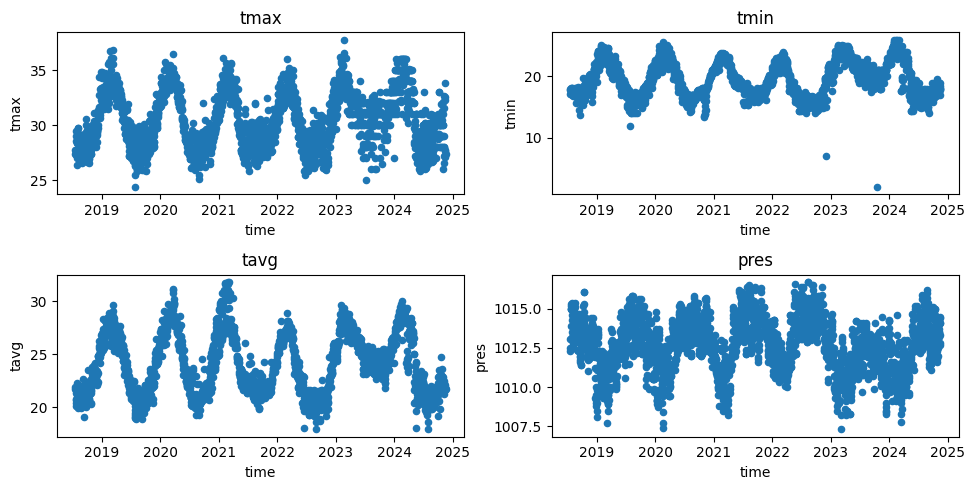

In [74]:
# Definimos la lista de columnas que queremos graficar
columnas_a_graficar = ['tmax', 'tmin', 'tavg', 'pres']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes = axes.flat

# Graficar cada columna en la lista
for ncol, colname in enumerate(columnas_a_graficar):
    if colname in df.columns: 
        df.plot(x='time', y=colname, kind='scatter', ax=axes[ncol])
        axes[ncol].set_title(colname) 
    else:
        print(f"Columna '{colname}' no encontrada en el DataFrame.")

plt.tight_layout() 
plt.show()


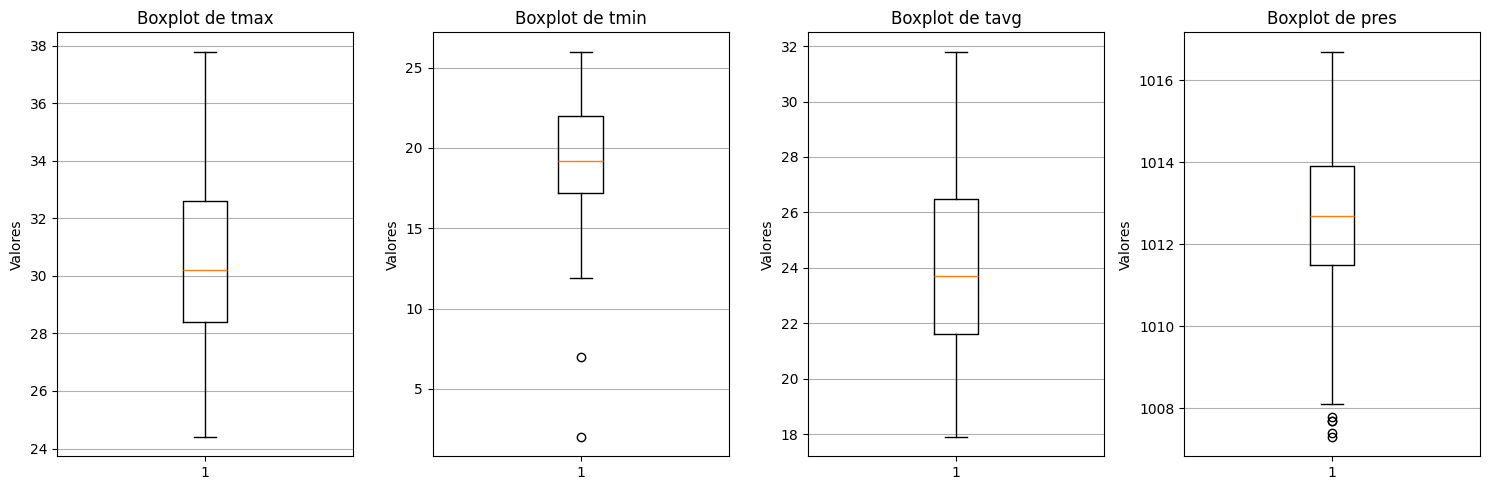

In [75]:
# Crear subplots
fig, axs = plt.subplots(1, len(columnas_a_graficar), figsize=(15, 5))  

# Crear boxplots horizontales
for ax, columna in zip(axs, columnas_a_graficar):
    ax.boxplot(df[columna])
    ax.set_title(f'Boxplot de {columna}')
    ax.set_ylabel('Valores')
    ax.grid(axis='y') 

plt.tight_layout() 
plt.show()

In [76]:
mean_temp_min = df['tmin'].mean()
df['tmin'] = df['tmin'].apply(lambda x: mean_temp_min if x < 10 else x)

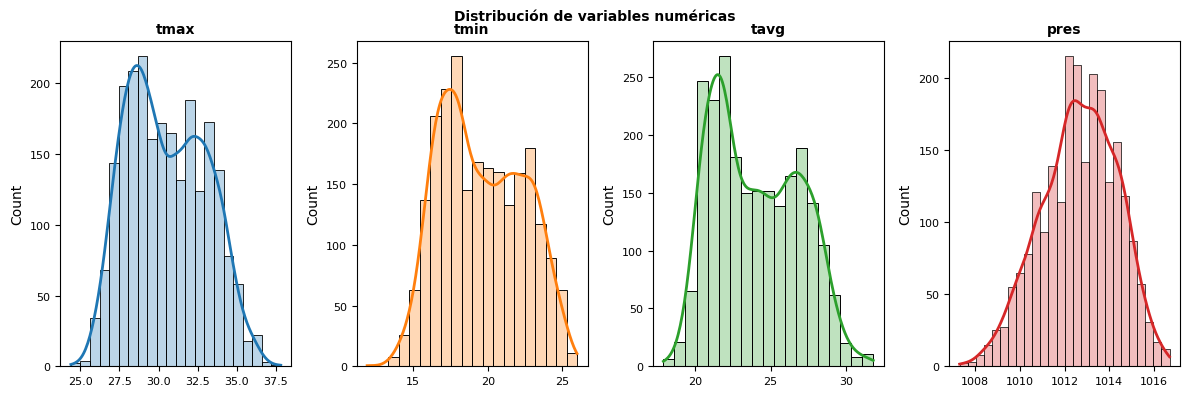

In [77]:
selected_columns = ['tmax', 'tmin', 'tavg', 'pres']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
axes = axes.flat

for i, column in enumerate(selected_columns):
    sns.histplot(
        data=df,
        x=column,
        stat="count",
        kde=True,
        color=(list(plt.rcParams['axes.prop_cycle'])*2)[i % 10]["color"],
        line_kws={'linewidth': 2},
        alpha=0.3,
        ax=axes[i]
    )
    axes[i].set_title(column, fontsize=10, fontweight="bold")
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de variables numéricas', fontsize=10, fontweight="bold")
plt.show()


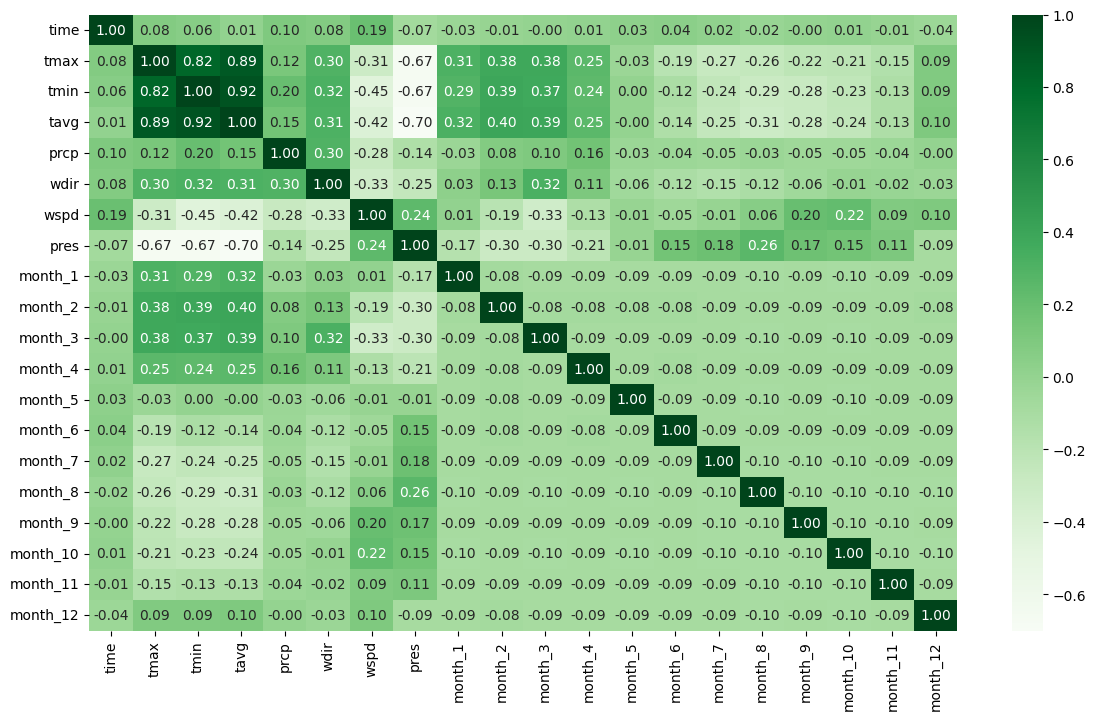

In [78]:
# Eliminar las columnas donde todos sus valores son 0 y la columna 'id_ciudad'
df_cleaned = df.loc[:, (df != 0).any(axis=0)]  # Eliminar columnas con todos ceros

# Excluir 'id_ciudad' si está presente en las columnas
if 'id_ciudad' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['id_ciudad'])

# Calcular la matriz de correlación de las columnas restantes
corr = df_cleaned.corr().round(2)

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(14, 8))
sns.heatmap(corr, cmap="Greens", annot=True, fmt=".2f")  # fmt controla el formato de anotación
plt.show()



In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2312 entries, 0 to 2311
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id_ciudad  2312 non-null   int64         
 1   time       2312 non-null   datetime64[ns]
 2   tmax       2312 non-null   float64       
 3   tmin       2312 non-null   float64       
 4   tavg       2312 non-null   float64       
 5   prcp       2312 non-null   float64       
 6   snow       2312 non-null   float64       
 7   wdir       2312 non-null   int64         
 8   wspd       2312 non-null   float64       
 9   wpgt       2312 non-null   float64       
 10  pres       2312 non-null   float64       
 11  tsun       2312 non-null   float64       
 12  month_1    2312 non-null   int32         
 13  month_2    2312 non-null   int32         
 14  month_3    2312 non-null   int32         
 15  month_4    2312 non-null   int32         
 16  month_5    2312 non-null   int32         
 17  

### Entrenamiento del modelo

#### Entrenar modelo

In [81]:
# Definir las características de entrada y las variables de salida
features = [col for col in df.columns if col not in ['id_ciudad', 'time','snow', 'wpgt', 'tsun']]
target_features = ['tmax', 'tmin', 'tavg']

# Dividir los datos en entrenamiento y validación
df_train = df[df['time'] <= '2023-12-31']
df_val = df[(df['time'] > '2023-12-31') & (df['time'] <= '2024-06-30')]
print(f'La data de entrenamiento tiene {len(df_train)} filas')
print(f'La data de validación tiene {len(df_val)} filas')

# Convertir las características de entrada y las salidas a formato numpy
input_data_train = df_train[features].values
input_data_val = df_val[features].values
targets_train = df_train[target_features].values
targets_val = df_val[target_features].values

# Definir la ventana de tiempo (T)
T = 20  # Número de pasos de tiempo
D = input_data_train.shape[1]  # Dimensión de las características de entrada
N_train = len(input_data_train) - T
N_val = len(input_data_val) - T
output_dim = len(target_features)  # Dimensión de salida

# Normalización de las entradas
scaler = StandardScaler()
scaler.fit(input_data_train[:len(input_data_train) + T - 1])
input_data_train = scaler.transform(input_data_train)
input_data_val = scaler.transform(input_data_val)

# Preparar X_train y y_train
X_train = np.zeros((N_train, T, D))
y_train = np.zeros((N_train, output_dim))

for t in range(N_train):
    X_train[t, :, :] = input_data_train[t:t+T]
    y_train[t] = targets_train[t+T]

# Preparar X_test y y_test
X_test = np.zeros((N_val, T, D))
y_test = np.zeros((N_val, output_dim))

for i in range(N_val):
    t = i
    X_test[i, :, :] = input_data_val[t:t+T]
    y_test[i] = targets_val[t+T]

# Convertir las matrices a tensores de PyTorch
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

# Verificación de las dimensiones
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

La data de entrenamiento tiene 1991 filas
La data de validación tiene 182 filas
X_train shape: torch.Size([1971, 20, 19]), y_train shape: torch.Size([1971, 3])
X_test shape: torch.Size([162, 20, 19]), y_test shape: torch.Size([162, 3])


In [82]:
# Guardar el scaler en un archivo
joblib.dump(scaler, 'escalado.pkl')

['escalado.pkl']

In [84]:
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import numpy as np

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # Capa LSTM
        self.lstm = nn.LSTM(input_size=input_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=layer_dim, 
                            batch_first=True)  # batch_first para tener (batch, seq, features)
        
        # Capa densa de salida
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        # Inicializar el estado oculto y de la celda
        h0 = torch.zeros(self.layer_dim, X.size(0), self.hidden_dim).to(X.device)
        c0 = torch.zeros(self.layer_dim, X.size(0), self.hidden_dim).to(X.device)

        # Pasar los datos a través de la capa LSTM
        out, (hn, cn) = self.lstm(X, (h0, c0))
        
        # Tomar la salida del último paso de la secuencia (h(T))
        out = self.fc(out[:, -1, :])  # Seleccionamos el último estado oculto
        return out


In [86]:
from tqdm import tqdm
import torch

def train(model, learning_rate, X_train, y_train, X_test, y_test, epochs=200):
    # Usar optimizador SGD con momentum y regularización L2 (weight_decay)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    criterion = torch.nn.MSELoss()  # Usando MSE como la función de pérdida

    history = {
        'loss': [], 'val_loss': [],
        'mae': [], 'val_mae': [],
        'mse': [], 'val_mse': []
    }

    # Barra de progreso en color verde
    with tqdm(total=epochs, desc="\033[32mTraining Model\033[0m", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} epochs", dynamic_ncols=True) as pbar:
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(X_train)
            train_loss = criterion(outputs, y_train)

            train_mae = torch.mean(torch.abs(outputs - y_train))
            train_mse = torch.mean((outputs - y_train) ** 2)

            train_loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_loss = criterion(test_outputs, y_test)

                test_mae = torch.mean(torch.abs(test_outputs - y_test))
                test_mse = torch.mean((test_outputs - y_test) ** 2)

            history['loss'].append(train_loss.item())
            history['val_loss'].append(test_loss.item())
            history['mae'].append(train_mae.item())
            history['val_mae'].append(test_mae.item())
            history['mse'].append(train_mse.item())
            history['val_mse'].append(test_mse.item())

            # Mostrar las métricas cada vez que se complete una época
            if (epoch + 1) % 100 == 0:
                print(f'At epoch {epoch+1} of {epochs}, Train Loss: {train_loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

            pbar.update(1)
            pbar.set_postfix(loss=train_loss.item(), val_loss=test_loss.item(), train_mae=train_mae.item(), val_mae=test_mae.item())

    return history


In [87]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dimensiones del modelo
input_dim = len(features)  # Número de características de entrada
hidden_dim = 2  # Dimensión de las capas ocultas
layer_dim = 1  # Número de capas LSTM
output_dim = len(target_features)  # Número de salidas 

# Crear el modelo LSTM
model = LSTM(input_dim, hidden_dim, layer_dim, output_dim)

# Mover el modelo a GPU o CPU
model.to(device) #https://github.com/cnzdgr/Weather-Forecast/blob/main/Weather_Prediction_using_LSTM.ipynb

LSTM(
  (lstm): LSTM(19, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=3, bias=True)
)

In [88]:
history = train(model,
                0.01,
                X_train,
                y_train,
                X_test,
                y_test,
                epochs=5)


Training Model: 100%|██████████| 5/5 epochs


In [60]:
historial = pd.DataFrame(history)
historial.head()

,loss,val_loss,mae,val_mae,mse,val_mse
0,629.813110,703.339050,24.603313,26.001226,629.813110,703.339050
1,621.118652,686.403137,24.430185,25.681797,621.118652,686.403137
2,604.861084,662.693909,24.103096,25.227396,604.861084,662.693909
3,582.096497,633.390686,23.637251,24.653580,582.096497,633.390686
4,553.865540,599.640198,23.045956,23.974930,553.865540,599.640198


In [61]:
"""
Prueba actual:
MAE: 0.24321879632054713 ~
RMSE: 0.33564318330897197 ~
"""

# Evaluación sobre el conjunto de test
model.eval()  # Establecer el modelo en modo evaluación (desactiva dropout y batchnorm)

with torch.no_grad():  # Desactiva el cálculo de gradientes para eficiencia de memoria
    # Realizar predicciones sobre el conjunto de test
    y_pred = model(X_test)
    
    # Convertir las predicciones y los valores reales a numpy para calcular las métricas
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Calcular las métricas: RMSE, MAE, MSE
    rmse_val = np.sqrt(mean_squared_error(y_test_np, y_pred_np))
    mae_val = mean_absolute_error(y_test_np, y_pred_np)
    mse_val = mean_squared_error(y_test_np, y_pred_np)

# Imprimir los resultados
print(f'RMSE: {rmse_val:.4f}')
print(f'MAE: {mae_val:.4f}')
print(f'MSE: {mse_val:.4f}')


RMSE: 24.4876
MAE: 23.9749
MSE: 599.6402


In [24]:
# Función para graficar la evolución de la pérdida, MAE y MSE con un rango de épocas
def plot_training_history(history, epoch_start=0, epoch_end=None, tamaño=0.01):
    # Determinar el rango de épocas
    if epoch_end is None:
        epoch_end = len(history['loss'])
    
    # Graficar la pérdida, MAE y MSE
    plt.figure(figsize=(18, 5))
    
    # Gráfico de la pérdida
    plt.subplot(1, 3, 1)
    plt.plot(range(epoch_start, epoch_end), history['loss'][epoch_start:epoch_end], label='Pérdida de Entrenamiento')
    plt.plot(range(epoch_start, epoch_end), history['val_loss'][epoch_start:epoch_end], label='Pérdida de Validación')
    plt.title('Evolución de la Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Inicial: {history["loss"][epoch_start]:.4f}', 
                 xy=(epoch_start, history["loss"][epoch_start]), 
                 xytext=(epoch_start, history["loss"][epoch_start] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))
    plt.annotate(f'Final: {history["loss"][epoch_end - 1]:.4f}', 
                 xy=(epoch_end - 1, history["loss"][epoch_end - 1]), 
                 xytext=(epoch_end - 1, history["loss"][epoch_end - 1] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))

    # Gráfico del MAE
    plt.subplot(1, 3, 2)
    plt.plot(range(epoch_start, epoch_end), history['mae'][epoch_start:epoch_end], label='MAE de Entrenamiento')
    plt.plot(range(epoch_start, epoch_end), history['val_mae'][epoch_start:epoch_end], label='MAE de Validación')
    plt.title('Evolución del MAE')
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Inicial: {history["mae"][epoch_start]:.4f}', 
                 xy=(epoch_start, history["mae"][epoch_start]), 
                 xytext=(epoch_start, history["mae"][epoch_start] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))
    plt.annotate(f'Final: {history["mae"][epoch_end - 1]:.4f}', 
                 xy=(epoch_end - 1, history["mae"][epoch_end - 1]), 
                 xytext=(epoch_end - 1, history["mae"][epoch_end - 1] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))

    # Gráfico del MSE
    plt.subplot(1, 3, 3)
    plt.plot(range(epoch_start, epoch_end), history['mse'][epoch_start:epoch_end], label='MSE de Entrenamiento')
    plt.plot(range(epoch_start, epoch_end), history['val_mse'][epoch_start:epoch_end], label='MSE de Validación')
    plt.title('Evolución del MSE')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.annotate(f'Inicial: {history["mse"][epoch_start]:.4f}', 
                 xy=(epoch_start, history["mse"][epoch_start]), 
                 xytext=(epoch_start, history["mse"][epoch_start] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))
    plt.annotate(f'Final: {history["mse"][epoch_end - 1]:.4f}', 
                 xy=(epoch_end - 1, history["mse"][epoch_end - 1]), 
                 xytext=(epoch_end - 1, history["mse"][epoch_end - 1] + tamaño),
                 arrowprops=dict(arrowstyle='->', color='black'))
    
    plt.tight_layout()
    plt.show()

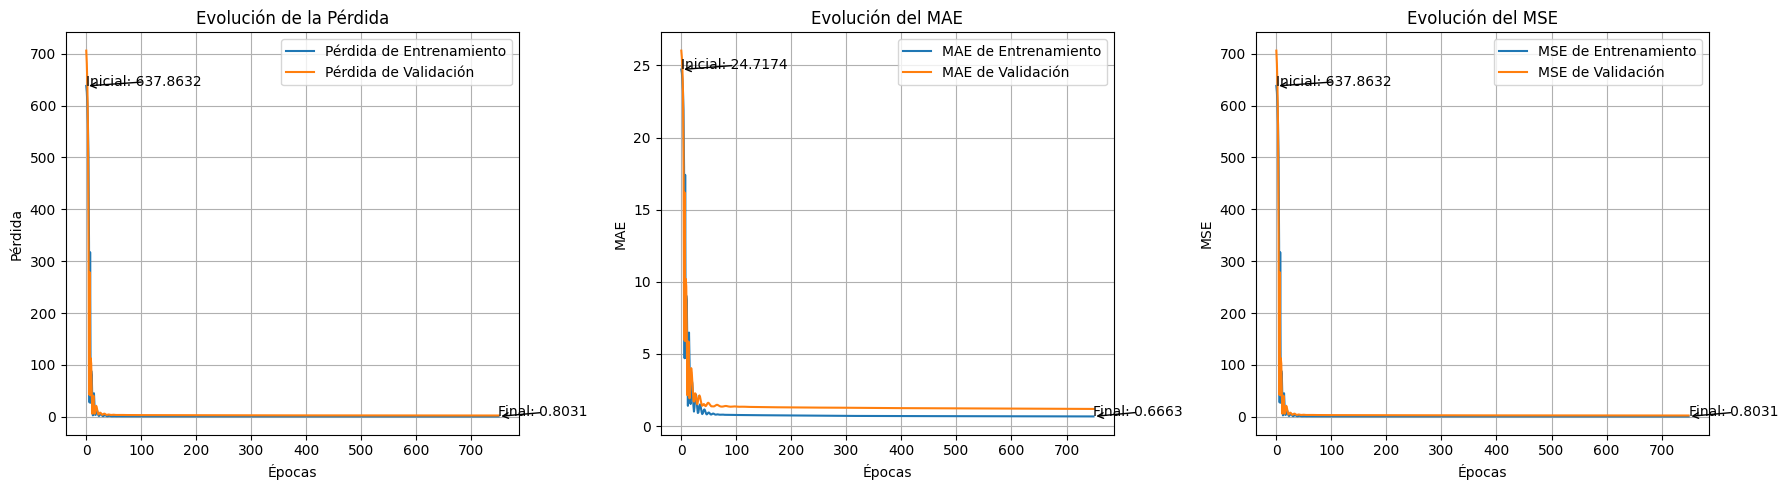

In [25]:
# Llamada a la función para graficar el historial
plot_training_history(history, epoch_start=0, epoch_end=None, tamaño=0.01)

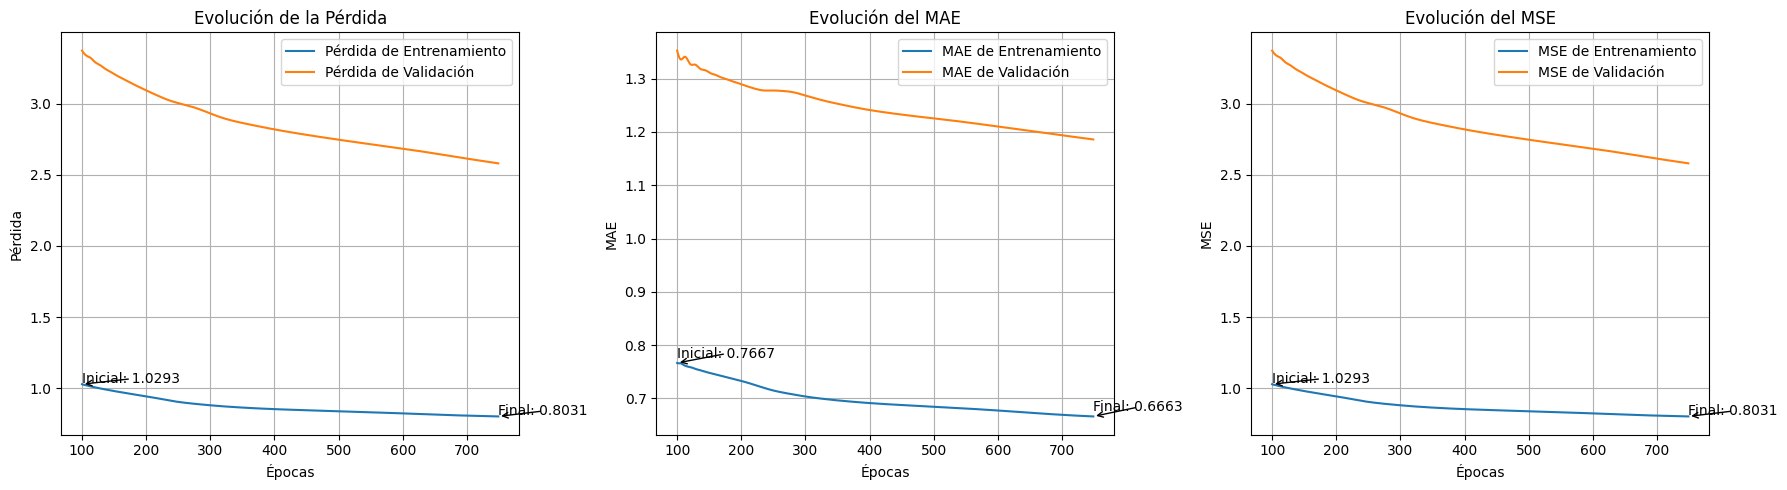

In [26]:
# Llamada a la función para graficar desde un intervalo "mas optimo"
plot_training_history(history, epoch_start=100, epoch_end=None, tamaño=0.01)

#### Evaluacion del modelo

##### Entrenamiento

In [27]:
# Establecer el modelo en modo de evaluación
model.eval()

# Realizar predicciones sin calcular gradientes sobre los datos de entrenamiento
with torch.no_grad():
    y_pred_train = model(X_train)

# Si es necesario, mover a la CPU y convertir a un array de NumPy
y_pred = y_pred_train.cpu().numpy() if y_pred_train.is_cuda else y_pred_train.numpy()

# Asegurarte de que y_train esté en formato NumPy también
y_train = y_train.cpu().numpy() if y_train.is_cuda else y_train.numpy()

# Ajustar y_train al tamaño de y_pred si es necesario
y_train = y_train[:y_pred.shape[0]]

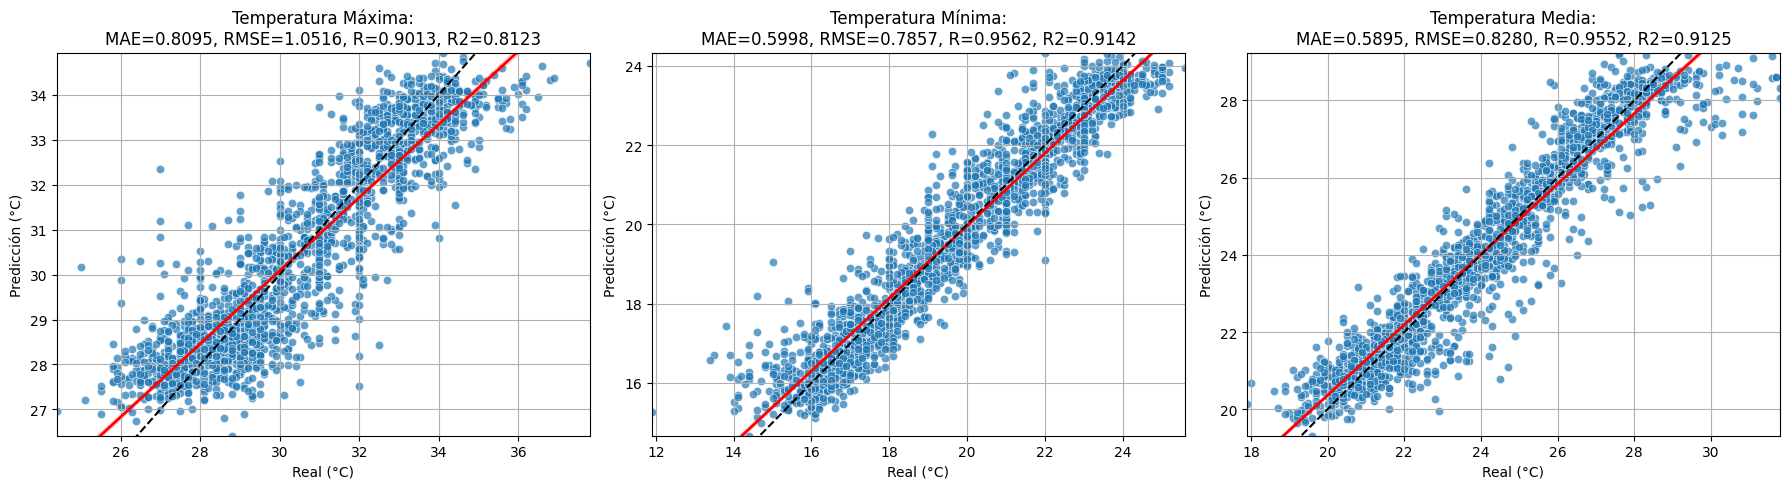

In [28]:
# Calcular los errores para cada temperatura en los datos de entrenamiento
error_max = y_train[:, 0] - y_pred[:, 0]
error_min = y_train[:, 1] - y_pred[:, 1]
error_media = y_train[:, 2] - y_pred[:, 2]

# Calcular las métricas de error para cada temperatura en los datos de entrenamiento
mae_max = mean_absolute_error(y_train[:, 0], y_pred[:, 0])
rmse_max = np.sqrt(mean_squared_error(y_train[:, 0], y_pred[:, 0]))
r2_max = r2_score(y_train[:, 0], y_pred[:, 0])
r_corr_max = np.corrcoef(y_train[:, 0], y_pred[:, 0])[0, 1]

mae_min = mean_absolute_error(y_train[:, 1], y_pred[:, 1])
rmse_min = np.sqrt(mean_squared_error(y_train[:, 1], y_pred[:, 1]))
r2_min = r2_score(y_train[:, 1], y_pred[:, 1])
r_corr_min = np.corrcoef(y_train[:, 1], y_pred[:, 1])[0, 1]

mae_media = mean_absolute_error(y_train[:, 2], y_pred[:, 2])
rmse_media = np.sqrt(mean_squared_error(y_train[:, 2], y_pred[:, 2]))
r2_media = r2_score(y_train[:, 2], y_pred[:, 2])
r_corr_media = np.corrcoef(y_train[:, 2], y_pred[:, 2])[0, 1]

# Crear el gráfico
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico para Temperatura Máxima
sns.scatterplot(ax=axs[0], x=y_train[:, 0], y=y_pred[:, 0], alpha=0.70)
sns.regplot(ax=axs[0], x=y_train[:, 0], y=y_pred[:, 0], scatter=False, color='red', line_kws={'linewidth': 2})
axs[0].plot([min(y_train[:, 0]), max(y_train[:, 0])], [min(y_train[:, 0]), max(y_train[:, 0])], color='black', linestyle='--')
axs[0].set_title(f'Temperatura Máxima:\nMAE={mae_max:.4f}, RMSE={rmse_max:.4f}, R={r_corr_max:.4f}, R2={r2_max:.4f}')
axs[0].set_xlabel('Real (°C)')
axs[0].set_ylabel('Predicción (°C)')
axs[0].set_ylim([min(y_pred[:, 0]), max(y_pred[:, 0])])
axs[0].set_xlim([min(y_train[:, 0]), max(y_train[:, 0])])
axs[0].grid(True)

# Gráfico para Temperatura Mínima
sns.scatterplot(ax=axs[1], x=y_train[:, 1], y=y_pred[:, 1], alpha=0.70)
sns.regplot(ax=axs[1], x=y_train[:, 1], y=y_pred[:, 1], scatter=False, color='red', line_kws={'linewidth': 2})
axs[1].plot([min(y_train[:, 1]), max(y_train[:, 1])], [min(y_train[:, 1]), max(y_train[:, 1])], color='black', linestyle='--')
axs[1].set_title(f'Temperatura Mínima:\nMAE={mae_min:.4f}, RMSE={rmse_min:.4f}, R={r_corr_min:.4f}, R2={r2_min:.4f}')
axs[1].set_xlabel('Real (°C)')
axs[1].set_ylabel('Predicción (°C)')
axs[1].set_ylim([min(y_pred[:, 1]), max(y_pred[:, 1])])
axs[1].set_xlim([min(y_train[:, 1]), max(y_train[:, 1])])
axs[1].grid(True)

# Gráfico para Temperatura Media
sns.scatterplot(ax=axs[2], x=y_train[:, 2], y=y_pred[:, 2], alpha=0.70)
sns.regplot(ax=axs[2], x=y_train[:, 2], y=y_pred[:, 2], scatter=False, color='red', line_kws={'linewidth': 2})
axs[2].plot([min(y_train[:, 2]), max(y_train[:, 2])], [min(y_train[:, 2]), max(y_train[:, 2])], color='black', linestyle='--')
axs[2].set_title(f'Temperatura Media:\nMAE={mae_media:.4f}, RMSE={rmse_media:.4f}, R={r_corr_media:.4f}, R2={r2_media:.4f}')
axs[2].set_xlabel('Real (°C)')
axs[2].set_ylabel('Predicción (°C)')
axs[2].set_ylim([min(y_pred[:, 2]), max(y_pred[:, 2])])
axs[2].set_xlim([min(y_train[:, 2]), max(y_train[:, 2])])
axs[2].grid(True)

plt.tight_layout()
plt.show()

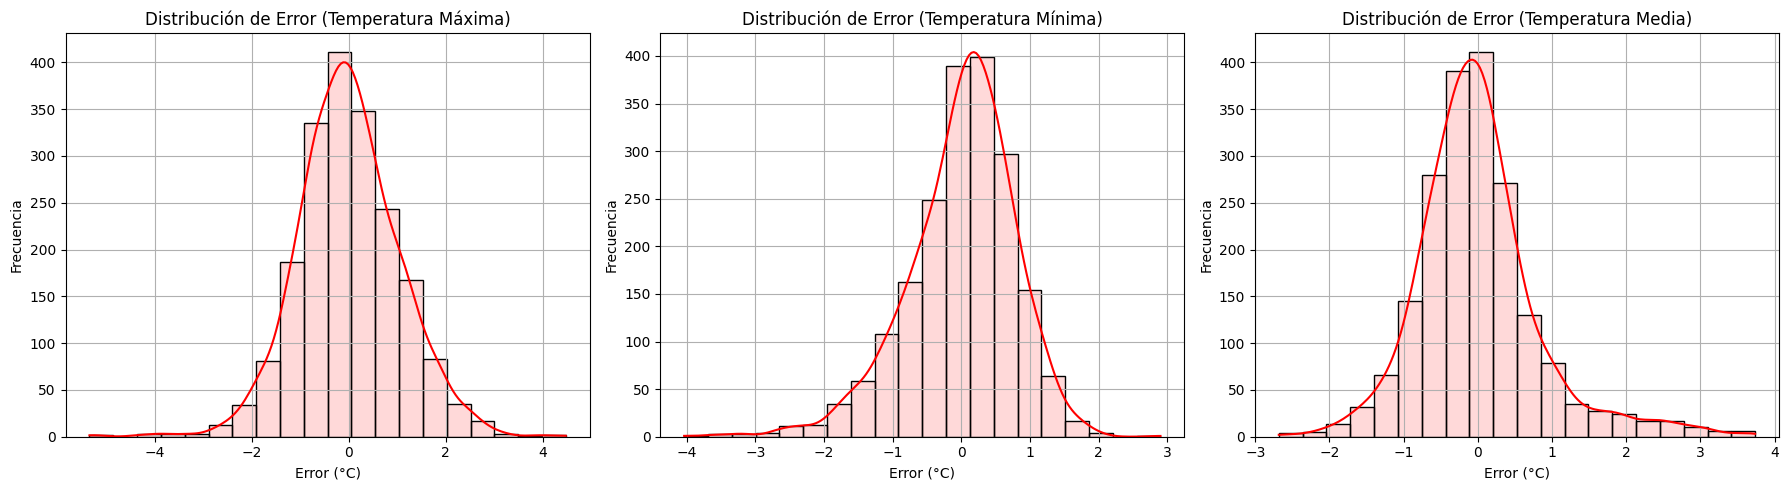

In [29]:
# Calcular los errores para cada temperatura en los datos de entrenamiento
error_max = y_train[:, 0] - y_pred[:, 0]
error_min = y_train[:, 1] - y_pred[:, 1]
error_media = y_train[:, 2] - y_pred[:, 2]

# Graficar la distribución de los errores usando histograma con KDE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribución de error en temperatura máxima (histograma con KDE)
sns.histplot(error_max, ax=axes[0], kde=True, color='red', bins=20, fill=True, alpha=0.15)
axes[0].set_title('Distribución de Error (Temperatura Máxima)')
axes[0].set_xlabel('Error (°C)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True)

# Distribución de error en temperatura mínima (histograma con KDE)
sns.histplot(error_min, ax=axes[1], kde=True, color='red', bins=20, fill=True, alpha=0.15)
axes[1].set_title('Distribución de Error (Temperatura Mínima)')
axes[1].set_xlabel('Error (°C)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True)

# Distribución de error en temperatura media (histograma con KDE)
sns.histplot(error_media, ax=axes[2], kde=True, color='red', bins=20, fill=True, alpha=0.15)
axes[2].set_title('Distribución de Error (Temperatura Media)')
axes[2].set_xlabel('Error (°C)')
axes[2].set_ylabel('Frecuencia')
axes[2].grid(True)

plt.tight_layout()
plt.show()

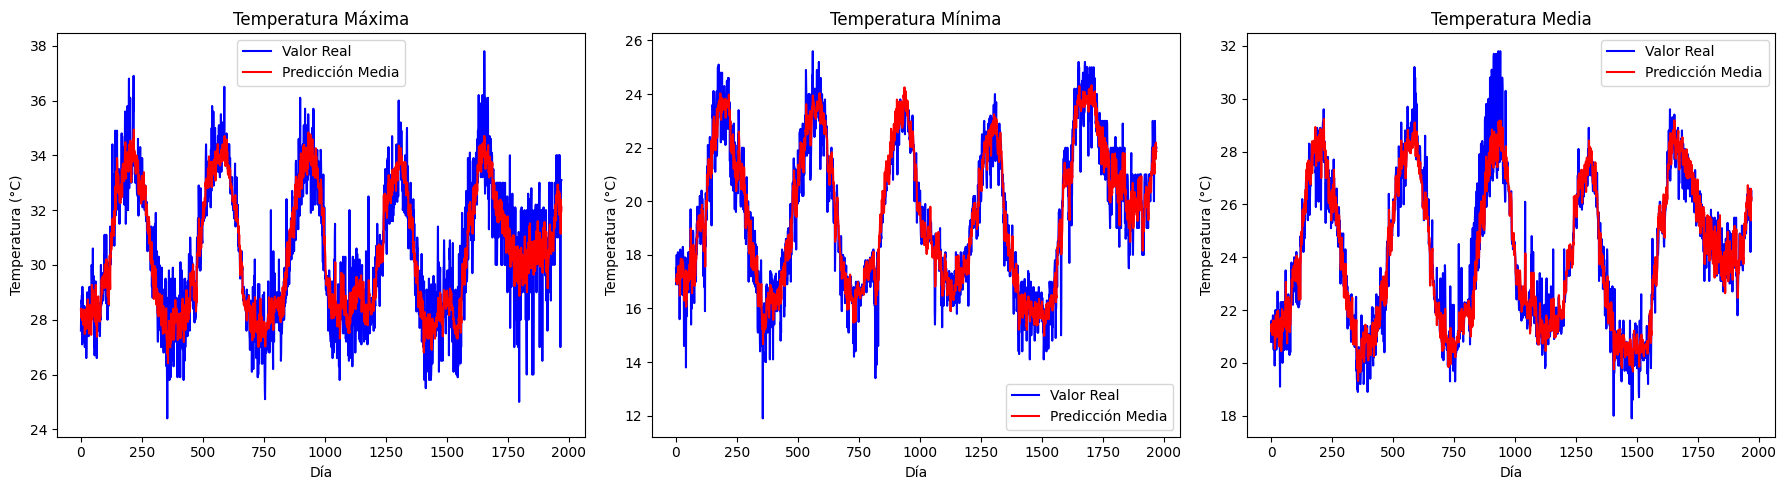

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperatura máxima
axes[0].plot(y_train[:, 0], label='Valor Real', color='blue')
axes[0].plot(y_pred[:, 0], label='Predicción Media', color='red')
axes[0].set_title('Temperatura Máxima')
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Temperatura (°C)')
axes[0].legend()

# Temperatura mínima
axes[1].plot(y_train[:, 1], label='Valor Real', color='blue')
axes[1].plot(y_pred[:, 1], label='Predicción Media', color='red')
axes[1].set_title('Temperatura Mínima')
axes[1].set_xlabel('Día')
axes[1].set_ylabel('Temperatura (°C)')
axes[1].legend()

# Temperatura media
axes[2].plot(y_train[:, 2], label='Valor Real', color='blue')
axes[2].plot(y_pred[:, 2], label='Predicción Media', color='red')
axes[2].set_title('Temperatura Media')
axes[2].set_xlabel('Día')
axes[2].set_ylabel('Temperatura (°C)')
axes[2].legend()

plt.tight_layout()
plt.show()

##### Validacion

In [31]:
# Establecer el modelo en modo de evaluación
model.eval()

# Realizar predicciones sin calcular gradientes
with torch.no_grad():
    y_pred_train = model(X_test)

# Si es necesario, mover a la CPU y convertir a un array de NumPy
y_pred = y_pred_train.cpu().numpy() if y_pred_train.is_cuda else y_pred_train.numpy()

# Asegurarte de que y_val esté en formato NumPy también
y_val = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Ajustar y_val al tamaño de y_pred si es necesario
y_val = y_val[:y_pred.shape[0]]

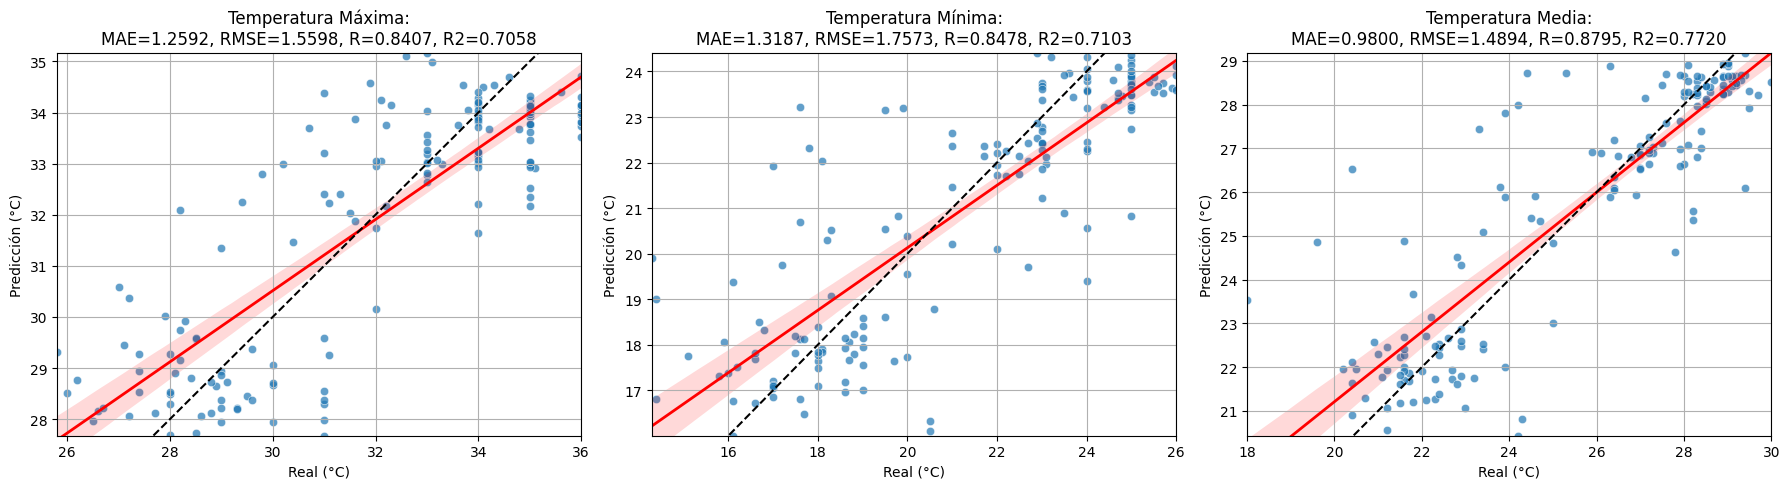

In [32]:
# Calcular los errores para cada temperatura
error_max = y_val[:, 0] - y_pred[:, 0]
error_min = y_val[:, 1] - y_pred[:, 1]
error_media = y_val[:, 2] - y_pred[:, 2]

# Calcular las métricas de error para cada temperatura
mae_max = mean_absolute_error(y_val[:, 0], y_pred[:, 0])
rmse_max = np.sqrt(mean_squared_error(y_val[:, 0], y_pred[:, 0]))
r2_max = r2_score(y_val[:, 0], y_pred[:, 0])
r_corr_max = np.corrcoef(y_val[:, 0], y_pred[:, 0])[0, 1]

mae_min = mean_absolute_error(y_val[:, 1], y_pred[:, 1])
rmse_min = np.sqrt(mean_squared_error(y_val[:, 1], y_pred[:, 1]))
r2_min = r2_score(y_val[:, 1], y_pred[:, 1])
r_corr_min = np.corrcoef(y_val[:, 1], y_pred[:, 1])[0, 1]

mae_media = mean_absolute_error(y_val[:, 2], y_pred[:, 2])
rmse_media = np.sqrt(mean_squared_error(y_val[:, 2], y_pred[:, 2]))
r2_media = r2_score(y_val[:, 2], y_pred[:, 2])
r_corr_media = np.corrcoef(y_val[:, 2], y_pred[:, 2])[0, 1]

# Crear el gráfico
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico para Temperatura Máxima
sns.scatterplot(ax=axs[0], x=y_val[:, 0], y=y_pred[:, 0], alpha=0.70)
sns.regplot(ax=axs[0], x=y_val[:, 0], y=y_pred[:, 0], scatter=False, color='red', line_kws={'linewidth': 2})
axs[0].plot([min(y_val[:, 0]), max(y_val[:, 0])], [min(y_val[:, 0]), max(y_val[:, 0])], color='black', linestyle='--')
axs[0].set_title(f'Temperatura Máxima:\nMAE={mae_max:.4f}, RMSE={rmse_max:.4f}, R={r_corr_max:.4f}, R2={r2_max:.4f}')
axs[0].set_xlabel('Real (°C)')
axs[0].set_ylabel('Predicción (°C)')
axs[0].set_ylim([min(y_pred[:, 0]), max(y_pred[:, 0])])
axs[0].set_xlim([min(y_val[:, 0]), max(y_val[:, 0])])
axs[0].grid(True)

# Gráfico para Temperatura Mínima
sns.scatterplot(ax=axs[1], x=y_val[:, 1], y=y_pred[:, 1], alpha=0.70)
sns.regplot(ax=axs[1], x=y_val[:, 1], y=y_pred[:, 1], scatter=False, color='red', line_kws={'linewidth': 2})
axs[1].plot([min(y_val[:, 1]), max(y_val[:, 1])], [min(y_val[:, 1]), max(y_val[:, 1])], color='black', linestyle='--')
axs[1].set_title(f'Temperatura Mínima:\nMAE={mae_min:.4f}, RMSE={rmse_min:.4f}, R={r_corr_min:.4f}, R2={r2_min:.4f}')
axs[1].set_xlabel('Real (°C)')
axs[1].set_ylabel('Predicción (°C)')
axs[1].set_ylim([min(y_pred[:, 1]), max(y_pred[:, 1])])
axs[1].set_xlim([min(y_val[:, 1]), max(y_val[:, 1])])
axs[1].grid(True)

# Gráfico para Temperatura Media
sns.scatterplot(ax=axs[2], x=y_val[:, 2], y=y_pred[:, 2], alpha=0.70)
sns.regplot(ax=axs[2], x=y_val[:, 2], y=y_pred[:, 2], scatter=False, color='red', line_kws={'linewidth': 2})
axs[2].plot([min(y_val[:, 2]), max(y_val[:, 2])], [min(y_val[:, 2]), max(y_val[:, 2])], color='black', linestyle='--')
axs[2].set_title(f'Temperatura Media:\nMAE={mae_media:.4f}, RMSE={rmse_media:.4f}, R={r_corr_media:.4f}, R2={r2_media:.4f}')
axs[2].set_xlabel('Real (°C)')
axs[2].set_ylabel('Predicción (°C)')
axs[2].set_ylim([min(y_pred[:, 2]), max(y_pred[:, 2])])
axs[2].set_xlim([min(y_val[:, 2]), max(y_val[:, 2])])
axs[2].grid(True)

plt.tight_layout()
plt.show()

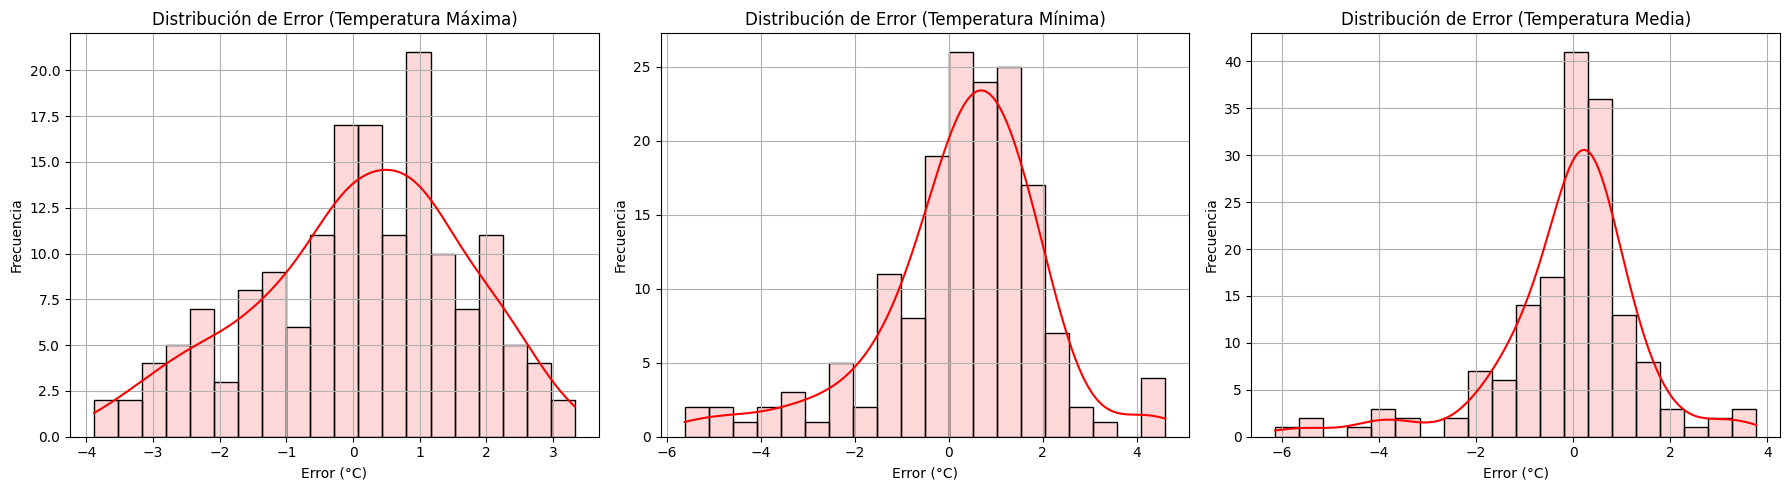

In [33]:
# Graficar la distribución de los errores usando histograma con KDE (Kernel Density Estimation)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribución de error en temperatura máxima (histograma con KDE)
sns.histplot(error_max, ax=axes[0], kde=True, color='red', bins=20, fill=True, alpha=0.15)
axes[0].set_title('Distribución de Error (Temperatura Máxima)')
axes[0].set_xlabel('Error (°C)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True)

# Distribución de error en temperatura mínima (histograma con KDE)
sns.histplot(error_min, ax=axes[1], kde=True, color='red', bins=20, fill=True, alpha=0.15)
axes[1].set_title('Distribución de Error (Temperatura Mínima)')
axes[1].set_xlabel('Error (°C)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True)

# Distribución de error en temperatura media (histograma con KDE)
sns.histplot(error_media, ax=axes[2], kde=True, color='red', bins=20, fill=True, alpha=0.15)
axes[2].set_title('Distribución de Error (Temperatura Media)')
axes[2].set_xlabel('Error (°C)')
axes[2].set_ylabel('Frecuencia')
axes[2].grid(True)

plt.tight_layout()
plt.show()


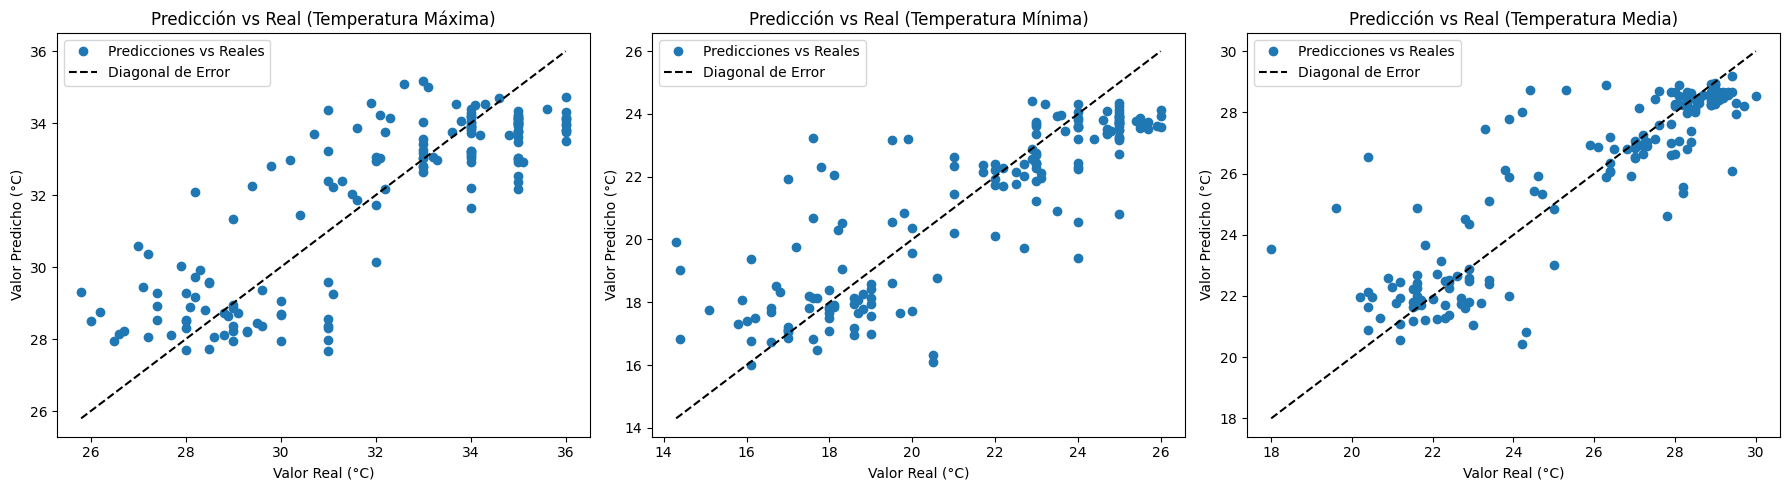

In [34]:
# Graficar la diagonal de error (predicciones vs reales)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Diagonal de error para temperatura máxima
axes[0].plot(y_val[:, 0], y_pred[:, 0], 'o', label='Predicciones vs Reales')
axes[0].plot([min(y_val[:, 0]), max(y_val[:, 0])], [min(y_val[:, 0]), max(y_val[:, 0])], 'k--', label='Diagonal de Error')
axes[0].set_title('Predicción vs Real (Temperatura Máxima)')
axes[0].set_xlabel('Valor Real (°C)')
axes[0].set_ylabel('Valor Predicho (°C)')
axes[0].legend()

# Diagonal de error para temperatura mínima
axes[1].plot(y_val[:, 1], y_pred[:, 1], 'o', label='Predicciones vs Reales')
axes[1].plot([min(y_val[:, 1]), max(y_val[:, 1])], [min(y_val[:, 1]), max(y_val[:, 1])], 'k--', label='Diagonal de Error')
axes[1].set_title('Predicción vs Real (Temperatura Mínima)')
axes[1].set_xlabel('Valor Real (°C)')
axes[1].set_ylabel('Valor Predicho (°C)')
axes[1].legend()

# Diagonal de error para temperatura media
axes[2].plot(y_val[:, 2], y_pred[:, 2], 'o', label='Predicciones vs Reales')
axes[2].plot([min(y_val[:, 2]), max(y_val[:, 2])], [min(y_val[:, 2]), max(y_val[:, 2])], 'k--', label='Diagonal de Error')
axes[2].set_title('Predicción vs Real (Temperatura Media)')
axes[2].set_xlabel('Valor Real (°C)')
axes[2].set_ylabel('Valor Predicho (°C)')
axes[2].legend()

plt.tight_layout()
plt.show()

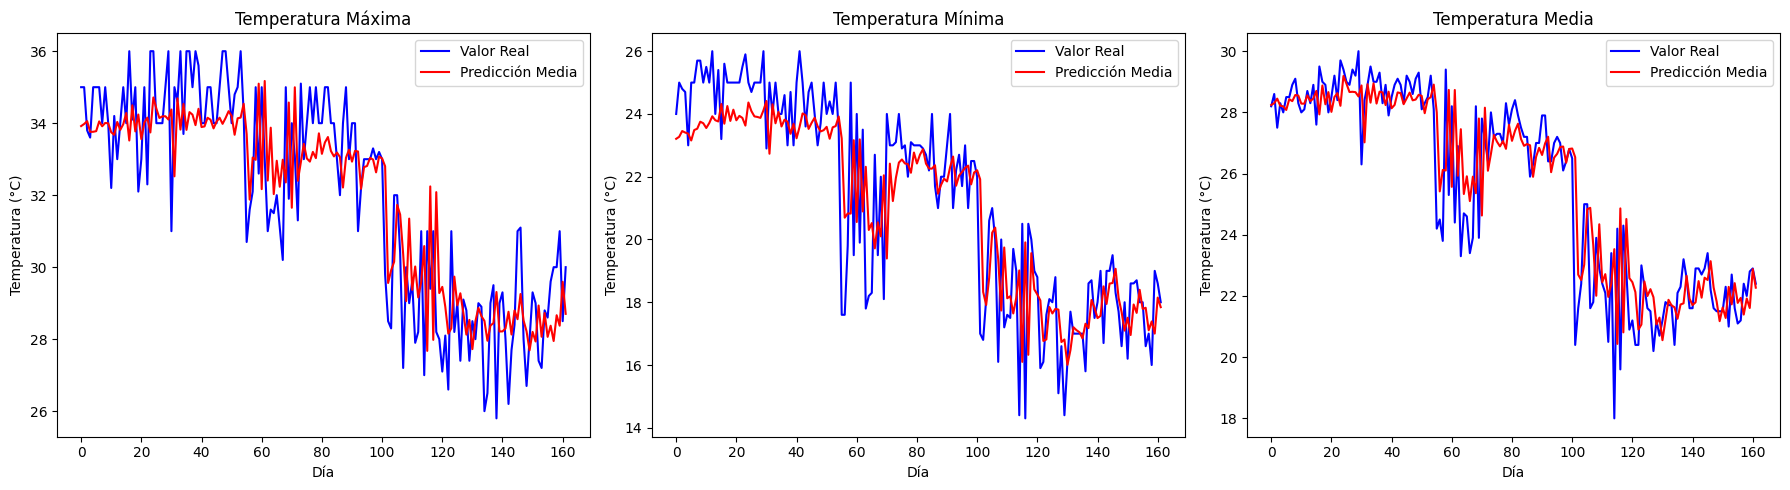

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperatura máxima
axes[0].plot(y_val[:, 0], label='Valor Real', color='blue')
axes[0].plot(y_pred[:, 0], label='Predicción Media', color='red')
axes[0].set_title('Temperatura Máxima')
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Temperatura (°C)')
axes[0].legend()

# Temperatura mínima
axes[1].plot(y_val[:, 1], label='Valor Real', color='blue')
axes[1].plot(y_pred[:, 1], label='Predicción Media', color='red')
axes[1].set_title('Temperatura Mínima')
axes[1].set_xlabel('Día')
axes[1].set_ylabel('Temperatura (°C)')
axes[1].legend()

# Temperatura media
axes[2].plot(y_val[:, 2], label='Valor Real', color='blue')
axes[2].plot(y_pred[:, 2], label='Predicción Media', color='red')
axes[2].set_title('Temperatura Media')
axes[2].set_xlabel('Día')
axes[2].set_ylabel('Temperatura (°C)')
axes[2].legend()

plt.tight_layout()
plt.show()

### Guardar Modelo

In [42]:
# Guardar el modelo completo (incluyendo la arquitectura y los pesos)
model_path = 'C:\\Users\\Ronaldo Olivares\\Desktop\\DOCUMENTO DE TESIS\\Codigos\\modelo_completo.pth'
torch.save(model, model_path)  # Guarda el modelo completo (incluyendo la arquitectura y los pesos)

print("Modelo guardado exitosamente en", model_path)

Modelo guardado exitosamente en C:\Users\Ronaldo Olivares\Desktop\DOCUMENTO DE TESIS\Codigos\modelo_completo.pth
